# 1. Imports

In [116]:
import torch
import torchvision
import matplotlib.pyplot as plt
import pandas as pd
from fastai.data.all import *
from fastai.vision.all import * 
import fastai

# 2. torch.einsum

## A. transpose

In [122]:
tsr = torch.arange(12).reshape(4,3)
tsr

tensor([[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8],
        [ 9, 10, 11]])

`-` 1번 방법

In [123]:
tsr.t()

tensor([[ 0,  3,  6,  9],
        [ 1,  4,  7, 10],
        [ 2,  5,  8, 11]])

`-` 2번 방법 

In [126]:
torch.einsum('ij -> ji' ,tsr)

tensor([[ 0,  3,  6,  9],
        [ 1,  4,  7, 10],
        [ 2,  5,  8, 11]])

1번이 더 쉬운데..? 왜 2번처럼 해야할까?

## B. 행렬곱

In [128]:
tsr1 = torch.arange(12).reshape(4,3).float()
tsr2 = torch.arange(15).reshape(3,5).float()

In [129]:
tsr1 @ tsr2

tensor([[ 25.,  28.,  31.,  34.,  37.],
        [ 70.,  82.,  94., 106., 118.],
        [115., 136., 157., 178., 199.],
        [160., 190., 220., 250., 280.]])

In [130]:
torch.einsum('ij,jk -> ik' ,tsr1,tsr2)

tensor([[ 25.,  28.,  31.,  34.,  37.],
        [ 70.,  82.,  94., 106., 118.],
        [115., 136., 157., 178., 199.],
        [160., 190., 220., 250., 280.]])

Matrix의 차원만 잘 지정하고 데이터를 적는다면 쉽게 행렬곱을 수행해준다.

## C. 이미지 변환

In [131]:
r = torch.zeros(16).reshape(4,4) + 1.0
g = torch.zeros(16).reshape(4,4)
b = torch.zeros(16).reshape(4,4)
img_plt = torch.stack([r,g,b],axis=-1) # matplotlib 를 쓰기 위해서는 이미지가 이렇게 저장되어있어야한다. 
img_torch = torch.stack([r,g,b],axis=0).reshape(1,3,4,4) # torch를 쓰기 위해서는 이미지가 이렇게 저장되어있어야한다. 

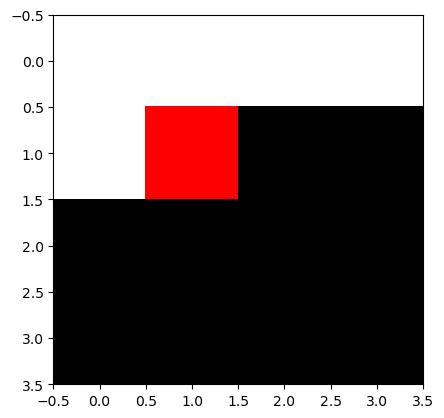

In [132]:
# 잘못된코드
plt.imshow(img_torch.reshape(4,4,3))

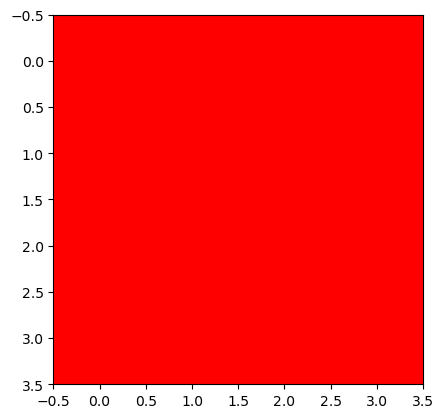

In [133]:
# 올바른코드
plt.imshow(torch.einsum('ocij -> ijc',img_torch))

원하는 건 빨간 배경인데 행렬곱을 위처럼 수행하면 프레임이 깨진다.

# 3. MNIST-직접설계

In [88]:
path = untar_data(URLs.MNIST)
path.ls()

(#2) [Path('/root/.fastai/data/mnist_png/training'),Path('/root/.fastai/data/mnist_png/testing')]

In [89]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in list(Path('/root/.fastai/data/mnist_png/training/0').ls())])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in list(Path('/root/.fastai/data/mnist_png/training/1').ls())])
X2 = torch.stack([torchvision.io.read_image(str(fname)) for fname in list(Path('/root/.fastai/data/mnist_png/training/2').ls())])
X = torch.concat([X0,X1,X2],axis=0)/255
y = torch.nn.functional.one_hot(torch.tensor([0]*len(X0) + [1]*len(X1) + [2]*len(X2))).float()
XX0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in list(Path('/root/.fastai/data/mnist_png/testing/0').ls())])
XX1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in list(Path('/root/.fastai/data/mnist_png/testing/1').ls())])
XX2 = torch.stack([torchvision.io.read_image(str(fname)) for fname in list(Path('/root/.fastai/data/mnist_png/testing/2').ls())])
XX = torch.concat([XX0,XX1,XX2],axis=0)/255
yy = torch.nn.functional.one_hot(torch.tensor([0]*len(XX0) + [1]*len(XX1) + [2]*len(XX2))).float()

In [90]:
print(X.shape)
print(y.shape)
print(XX.shape)
print(yy.shape)

torch.Size([18623, 1, 28, 28])
torch.Size([18623, 3])
torch.Size([3147, 1, 28, 28])
torch.Size([3147, 3])


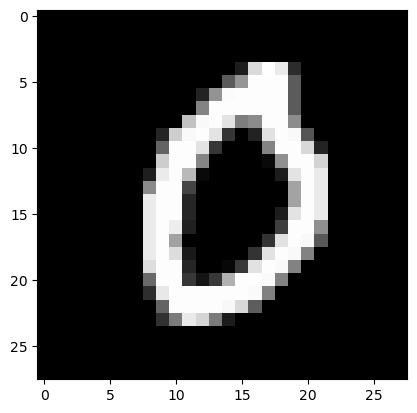

In [91]:
plt.imshow(torch.einsum('cij -> ijc',X[0]),cmap='grey')

(n,n,3)으로 차원이 설정되어 있어야 imshow를 할 수 있다.
    
(n,n,1)이면 흑백 3이면 컬러이다.

## A. y:(n,3) - float형

In [92]:
ds = torch.utils.data.TensorDataset(X,y)
dl = torch.utils.data.DataLoader(ds,batch_size=128)

net1 = torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten()
)

net2 = torch.nn.Sequential(
    torch.nn.Linear(2304,3)
)
net = torch.nn.Sequential(
    net1,
    net2
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters())
net.to('cuda:0')
for epoc in range(10):
    for xi,yi in dl:
        loss = loss_fn(net(xi.to('cuda:0')),yi.to('cuda:0'))
        loss.backward()
        optimizr.step()
        optimizr.zero_grad()

net.to('cpu')

print(f'train : {(net(X).data.argmax(axis=1) == y.argmax(axis=1)).float().mean():.4f}')
print(f'val : {(net(XX).data.argmax(axis=1) == yy.argmax(axis=1)).float().mean():.4f}')

train : 0.9812
val : 0.9873


`-` 항상 하던 것.

## B. y:(n,) - int형

In [93]:
X0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in list(Path('/root/.fastai/data/mnist_png/training/0').ls())])
X1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in list(Path('/root/.fastai/data/mnist_png/training/1').ls())])
X2 = torch.stack([torchvision.io.read_image(str(fname)) for fname in list(Path('/root/.fastai/data/mnist_png/training/2').ls())])
X = torch.concat([X0,X1,X2],axis=0)/255
y = torch.nn.functional.one_hot(torch.tensor([0]*len(X0) + [1]*len(X1) + [2]*len(X2))).float()
XX0 = torch.stack([torchvision.io.read_image(str(fname)) for fname in list(Path('/root/.fastai/data/mnist_png/testing/0').ls())])
XX1 = torch.stack([torchvision.io.read_image(str(fname)) for fname in list(Path('/root/.fastai/data/mnist_png/testing/1').ls())])
XX2 = torch.stack([torchvision.io.read_image(str(fname)) for fname in list(Path('/root/.fastai/data/mnist_png/testing/2').ls())])
XX = torch.concat([XX0,XX1,XX2],axis=0)/255
yy = torch.nn.functional.one_hot(torch.tensor([0]*len(XX0) + [1]*len(XX1) + [2]*len(XX2))).float()

In [94]:
y = y.argmax(axis=-1)
yy = yy.argmax(axis=-1)

y와 yy를 int형으로 바꿔야하기에 argmax함수를 이용했다.

In [134]:
print(X.shape)
print(y.shape)
print(XX.shape)
print(yy.shape)

torch.Size([60000, 1, 28, 28])
torch.Size([60000])
torch.Size([10000, 1, 28, 28])
torch.Size([10000])


In [96]:
ds = torch.utils.data.TensorDataset(X,y)
dl = torch.utils.data.DataLoader(ds,batch_size=128)

net1 =  torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten()
)
net2 = torch.nn.Sequential(
    torch.nn.Linear(2304,3)
)
net = torch.nn.Sequential(
    net1,
    net2
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters())
net.to('cuda:0')
for epoc in range(10):
    for xi,yi in dl:
        # netout = net(xi.to('cuda:0'))
        loss = loss_fn(net(xi.to('cuda:0')),yi.to('cuda:0'))
        loss.backward()
        optimizr.step()
        optimizr.zero_grad()
net.to("cpu")
print(f'train : {(net(X).data.argmax(axis=1) == y).float().mean():.4f}')
print(f'val : {(net(XX).data.argmax(axis=1) == yy).float().mean():.4f}')

train : 0.9767
val : 0.9854


`-` 손실함수로 torch.nn.CrossEntropyLoss()를 사용하면 one_hot_encoding , float형 전처리 모두 필요없다 알아서 다 해줌

`-` 받아야하는 class가 1보다 크면 CrossEntropyLoss()를 사용

# 4. Fashion-MNIST

In [98]:
df_train=pd.read_csv('https://media.githubusercontent.com/media/guebin/PP2023/main/posts/fashion-mnist_train.csv')
df_test=pd.read_csv('https://media.githubusercontent.com/media/guebin/PP2023/main/posts/fashion-mnist_test.csv')
def rshp(row):
    return row.reshape(1,28,28)
X = torch.tensor(np.apply_along_axis(rshp,axis=1,arr=np.array(df_train.iloc[:,1:]))).float()
XX  = torch.tensor(np.apply_along_axis(rshp,axis=1,arr=np.array(df_test.iloc[:,1:]))).float()
y = torch.tensor(np.array(df_train.label))
yy  = torch.tensor(np.array(df_test.label))

In [99]:
print(X.shape,'\t',X.dtype)
print(y.shape,'\t\t\t',y.dtype)
print(XX.shape,'\t',XX.dtype)
print(yy.shape,'\t\t\t',yy.dtype)

torch.Size([60000, 1, 28, 28]) 	 torch.float32
torch.Size([60000]) 			 torch.int64
torch.Size([10000, 1, 28, 28]) 	 torch.float32
torch.Size([10000]) 			 torch.int64


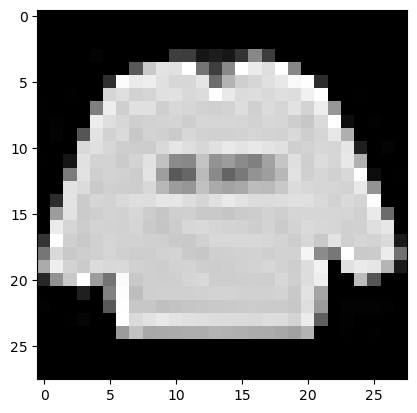

In [100]:
plt.imshow(torch.einsum('cij -> ijc',X[0]),cmap="gray")

## A. torch

In [109]:
ds = torch.utils.data.TensorDataset(X,y)
dl = torch.utils.data.DataLoader(ds,batch_size=128)

net1 = torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten()
)
net2 = torch.nn.Sequential(
    torch.nn.Linear(2304,10)
)
net = torch.nn.Sequential(
    net1,
    net2
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters())
net.to('cuda:0')
for epoc in range(10):
    for xi,yi in dl:
        netout = net(xi.to('cuda:0'))
        loss = loss_fn(netout,yi.to('cuda:0'))
        loss.backward()
        optimizr.step()
        optimizr.zero_grad()
net.to('cpu')

print(f'train: {(net(X).data.argmax(axis=1) == y).float().mean():.4f}')
print(f'val: {(net(XX).data.argmax(axis=1) == yy).float().mean():.4f}')

train: 0.9089
val: 0.8701


`-` 항상 하던 것

`-` 받아야하는 class가 10개니까 torch.nn.CrossEntropyLoss() 사용하고 어자피 float형 안 맞춰도 되니까 y를 int형으로 설정

## B. fastai

In [119]:
# Step1: 데이터정리 (dls생성)
ds1 = torch.utils.data.TensorDataset(X,y)
ds2 = torch.utils.data.TensorDataset(XX,yy)
dl1 = torch.utils.data.DataLoader(ds1,batch_size=128)
dl2 = torch.utils.data.DataLoader(ds2,batch_size=128)
dls = fastai.data.core.DataLoaders(dl1,dl2)
# Step2: 적합에 필요한 오브젝트 생성
net1 = torch.nn.Sequential(
    torch.nn.Conv2d(1,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten()
)
net2 = torch.nn.Sequential(
    torch.nn.Linear(2304,10),
)
net = torch.nn.Sequential(
    net1, # 2d-part
    net2, # 1d-part 
)
loss_fn = torch.nn.CrossEntropyLoss()
# optimizr = torch.optim.Adam(net.parameters())
# Step3: 적합 
lrnr = fastai.learner.Learner(
    dls=dls,
    model = net,
    loss_func = loss_fn,
    metrics = [fastai.metrics.accuracy]
)

lrnr.fit(10)

# Step4: 예측 및 평가 
lrnr.model.to('cpu')

print(f'train: {(net(X).data.argmax(axis=1) == y).float().mean():.4f}')
print(f'val: {(net(XX).data.argmax(axis=1) == yy).float().mean():.4f}')

epoch,train_loss,valid_loss,accuracy,time
0,0.541958,0.464602,0.851200,00:01
1,0.402498,0.436741,0.859500,00:01
2,0.353617,0.427963,0.865000,00:01
3,0.319062,0.429699,0.869100,00:01
4,0.297310,0.442318,0.869700,00:01
5,0.284193,0.457588,0.870200,00:01
6,0.275215,0.462712,0.873100,00:01
7,0.264285,0.461538,0.872100,00:01
8,0.260774,0.467244,0.874800,00:01
9,0.253124,0.481810,0.874100,00:01


train: 0.9161
val: 0.8741


`-` 조금 새롭게 fastai 이용

optimizr 사용 안 해도 된다. lrnr 새롭게 정의해서 손실함수 넣어주고 원하는 적합기준 정해주면 된다.
    
for epoc 귀찮게 길게 쓸 필요 없이 fit하면 바로 학습

lrnr 사용하면 to.('cuda:0') 사용 할 필요없이 바로 GPU로 연산해준다.

# 5. CIFAR10 – transfer

## A. 데이터 불러오기 및 전처리

In [135]:
path = fastai.data.external.untar_data(fastai.data.external.URLs.CIFAR)
path.ls()

(#3) [Path('/root/.fastai/data/cifar10/train'),Path('/root/.fastai/data/cifar10/labels.txt'),Path('/root/.fastai/data/cifar10/test')]

In [142]:
labels = [str(l).split('/')[-1] for l in (path/'train').ls()]
labels

['deer',
 'airplane',
 'ship',
 'dog',
 'automobile',
 'truck',
 'cat',
 'frog',
 'horse',
 'bird']

In [143]:
X = torch.stack([torchvision.io.read_image(str(fname)) for l in labels for fname in (path/f'train/{l}').ls()],axis=0).float()/255
XX = torch.stack([torchvision.io.read_image(str(fname)) for l in labels for fname in (path/f'test/{l}').ls()],axis=0).float()/255
y = torch.tensor([i for i,l in enumerate(labels) for fname in (path/f'train/{l}').ls()])
yy = torch.tensor([i for i,l in enumerate(labels) for fname in (path/f'test/{l}').ls()])

In [144]:
print(X.shape,'\t',X.dtype)
print(y.shape,'\t\t\t',y.dtype)
print(XX.shape,'\t',XX.dtype)
print(yy.shape,'\t\t\t',yy.dtype)

torch.Size([50000, 3, 32, 32]) 	 torch.float32
torch.Size([50000]) 			 torch.int64
torch.Size([10000, 3, 32, 32]) 	 torch.float32
torch.Size([10000]) 			 torch.int64


Text(0.5, 1.0, 'cat,6')

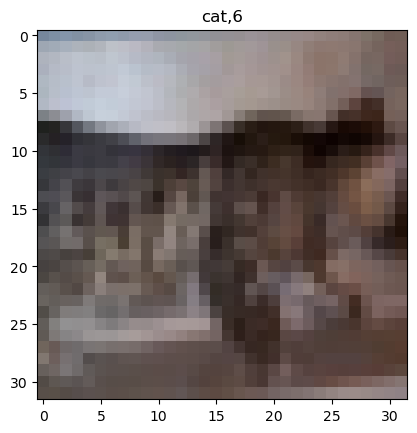

In [145]:
ylabel = [l for l in labels for fname in (path/f'train/{l}').ls()]
i = 30002
plt.imshow(torch.einsum('cij->ijc',X[i]))
plt.title(f'{ylabel[i]},{y[i]}')

`-` 쓰읍...뭐지? 어렵겠는데?

In [ ]:
ds1 = torch.utils.data.TensorDataset(X,y)
ds2 = torch.utils.data.TensorDataset(XX,yy)
dl1 = torch.utils.data.DataLoader(ds1,batch_size=256,shuffle=True)
dl2 = torch.utils.data.DataLoader(ds2,batch_size=100)
dls = fastai.data.core.DataLoaders(dl1,dl2)

## B. 수제네트워크로 학습

In [146]:
# Step1:
ds1 = torch.utils.data.TensorDataset(X,y)
ds2 = torch.utils.data.TensorDataset(XX,yy)
dl1 = torch.utils.data.DataLoader(ds1,batch_size=256)
dl2 = torch.utils.data.DataLoader(ds2,batch_size=100)
dls = fastai.data.core.DataLoaders(dl1,dl2)
# Step2:
net1 = torch.nn.Sequential(
    torch.nn.Conv2d(3,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten()
)
net2 = torch.nn.Sequential(
    torch.nn.Linear(3136,10),
)
net = torch.nn.Sequential(
    net1, # 2d-part
    net2, # 1d-part 
)
loss_fn = torch.nn.CrossEntropyLoss()
lrnr = fastai.learner.Learner(
    dls=dls,
    model=net,
    loss_func=loss_fn,
    #--#
    metrics=[fastai.metrics.accuracy]
)
# Step3:
lrnr.fit(10)
# Step4: 
lrnr.model.to("cpu")
print(f'train: {(lrnr.model(X).data.argmax(axis=1) == y).float().mean():.4f}')
print(f'val: {(lrnr.model(XX).data.argmax(axis=1) == yy).float().mean():.4f}')

epoch,train_loss,valid_loss,accuracy,time
0,2.433561,2.301266,0.111900,00:00
1,2.410473,2.299356,0.111600,00:00
2,2.479004,2.294760,0.129800,00:00
3,2.709449,2.291229,0.132000,00:01
4,2.522834,2.285669,0.141500,00:00
5,2.564267,2.291603,0.152500,00:00
6,2.335277,22.824865,0.100000,00:00
7,2.451625,2.266450,0.154900,00:00
8,2.779048,2.276835,0.134400,00:00
9,2.322695,15.980297,0.100000,00:01


train: 0.1000
val: 0.1000


`-` 적합결과가... 너무....낮은데?

`-` shuffle 해보자

In [147]:
# Step1:
ds1 = torch.utils.data.TensorDataset(X,y)
ds2 = torch.utils.data.TensorDataset(XX,yy)
dl1 = torch.utils.data.DataLoader(ds1,batch_size=256,shuffle=True)
dl2 = torch.utils.data.DataLoader(ds2,batch_size=100)
dls = fastai.data.core.DataLoaders(dl1,dl2)
# Step2:
net1 = torch.nn.Sequential(
    torch.nn.Conv2d(3,16,(5,5)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d((2,2)),
    torch.nn.Flatten()
)
net2 = torch.nn.Sequential(
    torch.nn.Linear(3136,10),
)
net = torch.nn.Sequential(
    net1, # 2d-part
    net2, # 1d-part 
)
loss_fn = torch.nn.CrossEntropyLoss()
lrnr = fastai.learner.Learner(
    dls=dls,
    model=net,
    loss_func=loss_fn,
    #--#
    metrics=[fastai.metrics.accuracy]
)
# Step3:
lrnr.fit(10)
# Step4: 
lrnr.model.to("cpu")
print(f'train: {(lrnr.model(X).data.argmax(axis=1) == y).float().mean():.4f}')
print(f'val: {(lrnr.model(XX).data.argmax(axis=1) == yy).float().mean():.4f}')

epoch,train_loss,valid_loss,accuracy,time
0,1.592431,1.526400,0.457100,00:01
1,1.417399,1.401563,0.505400,00:01
2,1.346312,1.337707,0.530100,00:01
3,1.289108,1.314588,0.537600,00:00
4,1.251300,1.248085,0.561200,00:01
5,1.217364,1.244665,0.565400,00:01
6,1.189324,1.224657,0.570000,00:01
7,1.164597,1.191183,0.583000,00:01
8,1.140757,1.186900,0.585600,00:00
9,1.117297,1.169561,0.596800,00:00


train: 0.6298
val: 0.5968


`-` shuffle 하나로 이렇게 상승한다고?

## C. TransferLearning

`-` 남들이 만들어놓은 좋은 model을 가져와서 써보자

In [148]:
net = torchvision.models.resnet18()
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

`-` 마지막만 바꾸는 건 받아야하는 class의 개수가 원래 net과 다르니 이 부분을 바꿔준다

In [149]:
net.fc = torch.nn.Linear(512,10)

In [150]:
# Step1:
ds1 = torch.utils.data.TensorDataset(X,y)
ds2 = torch.utils.data.TensorDataset(XX,yy)
dl1 = torch.utils.data.DataLoader(ds1,batch_size=64,shuffle=True)
dl2 = torch.utils.data.DataLoader(ds2,batch_size=100)
dls = fastai.data.core.DataLoaders(dl1,dl2)
# Step2:
net = torchvision.models.resnet18()
net.fc = torch.nn.Linear(512,10)
loss_fn = torch.nn.CrossEntropyLoss()
lrnr = fastai.learner.Learner(
    dls=dls,
    model=net,
    loss_func=loss_fn,
    #--#
    metrics=[fastai.metrics.accuracy]
)
# Step3:
lrnr.fit(10)
# Step4: 
# 코랩사용시 아래는 주석처리할것 (이유: 코랩의 RAM이 충분하지 않음) valiation set의 accuracy는 fastai결과로 확인할것. 
lrnr.model.to("cpu")
print(f'train: {(lrnr.model(X).data.argmax(axis=1) == y).float().mean():.4f}') # 
print(f'val: {(lrnr.model(XX).data.argmax(axis=1) == yy).float().mean():.4f}')

epoch,train_loss,valid_loss,accuracy,time
0,1.187585,1.287988,0.556600,00:11
1,0.948455,0.954595,0.673700,00:11
2,0.800781,1.140621,0.629100,00:11
3,0.673832,0.857950,0.709800,00:11
4,0.604290,1.005834,0.677700,00:11
5,0.497186,0.754922,0.747400,00:10
6,0.415167,0.770542,0.756200,00:11
7,0.349538,0.815337,0.758800,00:11
8,0.290415,1.048183,0.722400,00:11
9,0.242629,0.965163,0.742200,00:11


train: 0.9302
val: 0.7421


`-` 오버피팅이 좀 있지만 꽤 잘 맞춘다

`-` 결론 : 남들이 쓰는 거 가져다가 살짝 바꿔서 쓰는 게 잘 나오긴 한다...